# Customer Segmentation

# Summary
This notebook presents a unsupervised machine learning project segmenting a credit card customer base into  distinct groups. By applying clustering algorithms such as K-Means, Agglomerative Clustering, and Gaussian Mixture Models, the analysis reveals meaningful customer segments: balanced traditional users, support-dependent low-tier users, and high-value digital-first customers. Key behavioral and financial features like channel preference and engagement intensity drive these segments, providing actionable insights for personalized marketing, product strategies, and optimized customer support.

## Prerequisites

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [ ]:
df = pd.read_excel("Credit Card Customer Data.xlsx")

## Data Overview

In [3]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [4]:
df.shape

(660, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


In [7]:
df.duplicated().sum()

0

## Explatory Data Analysis

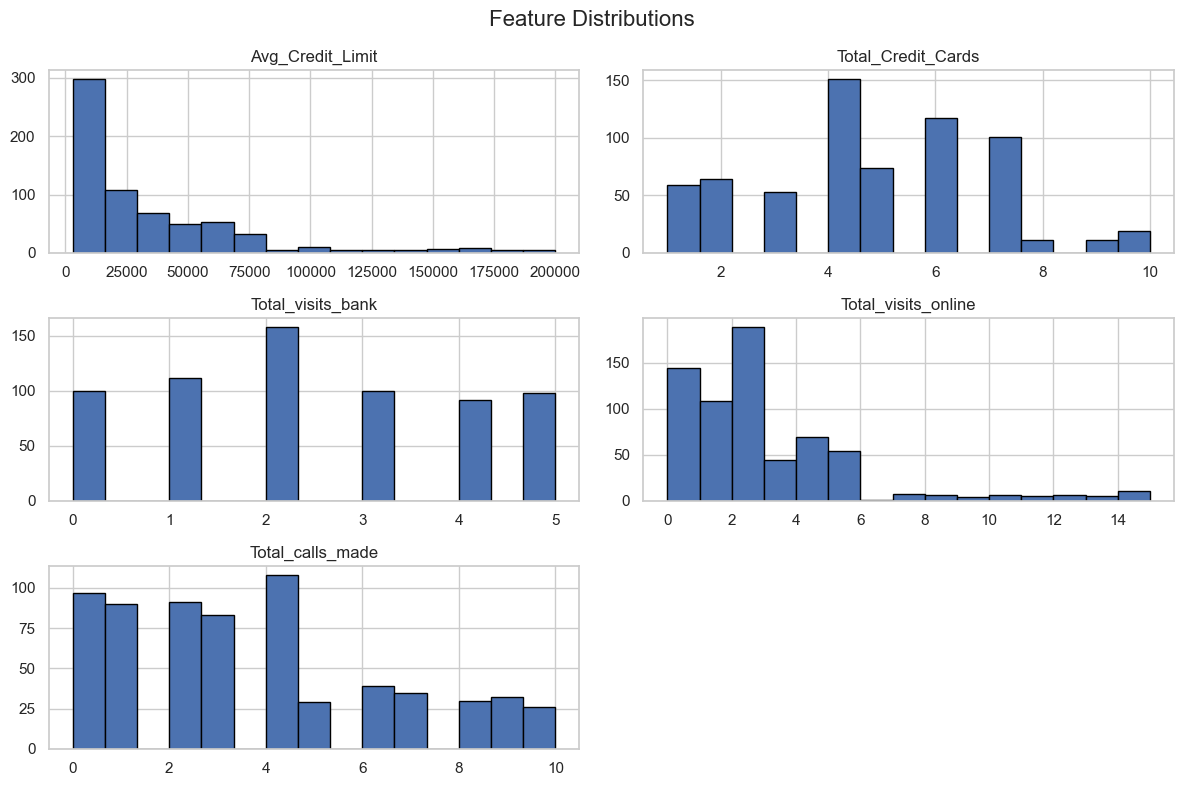

In [12]:
df.hist(figsize=(12, 8), bins=15, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

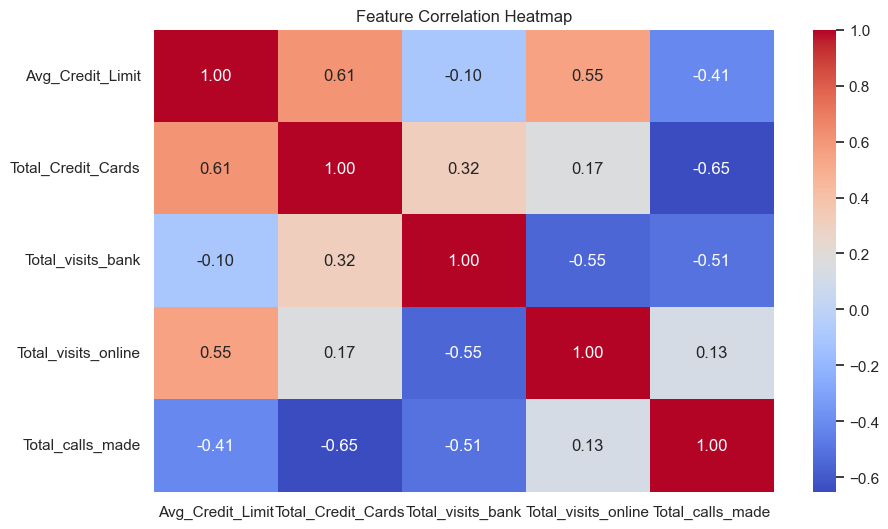

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [14]:
print("Skewness per feature:\n")
print(df.skew())

Skewness per feature:

Avg_Credit_Limit       2.202396
Total_Credit_Cards     0.144879
Total_visits_bank      0.141896
Total_visits_online    2.225607
Total_calls_made       0.658905
dtype: float64


### Observations:

- Skewed Features:

    - Avg_Credit_Limit and Total_visits_online are heavily right-skewed we should apply np.log1p() transformation.

    - Total_calls_made has moderate skew but doesn't require immediate correction.

- Feature Distributions:

    - Total_Credit_Cards is roughly normal.

    - Total_visits_bank is uniformly spread, indicating consistent offline engagement.

- Correlations:

    - Avg_Credit_Limit correlates positively with Total_Credit_Cards (+0.61) and Total_visits_online (+0.55).

    - Total_calls_made is negatively correlated with both Avg_Credit_Limit (–0.41) and Total_Credit_Cards (–0.65).

    - Total_visits_online and Total_visits_bank are inversely correlated (–0.55), suggesting distinct digital vs. traditional user types.




## Data Preparation

In [10]:
df[df['Customer Key'].duplicated(keep=False)]

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
4,5,47437,100000,6,0,12,3
48,49,37252,6000,4,0,2,8
104,105,97935,17000,2,1,2,10
332,333,47437,17000,7,3,1,0
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2
411,412,50706,44000,4,5,0,2
432,433,37252,59000,6,2,1,2
541,542,50706,60000,7,5,2,2
632,633,97935,187000,7,1,7,0


In [11]:
df = df.drop_duplicates(subset="Customer Key", keep="first").reset_index(drop=True)

In [12]:
# Dropping features which do not hold valuable info
df.drop(columns=["Sl_No", "Customer Key"], inplace=True)

Now, that we have dropped unnecessary columns, we can again check for duplicates. Duplicates would mean customers with identical features.

In [13]:
df[df.duplicated()]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
162,8000,2,0,3,4
175,6000,1,0,2,5
215,8000,4,0,4,7
295,10000,6,4,2,3
324,9000,4,5,0,4
360,18000,6,3,1,4
377,12000,6,5,2,1
384,8000,7,4,2,0
394,5000,4,5,0,1
452,47000,6,2,0,4


In [14]:
df = df[~df.duplicated()]

In [15]:
df.shape

(644, 5)

After removing the duplicate keys, the duplicate rows, and dropping unnecessary columns, there are 644 unique observations and 5 columns in our data.

In [16]:
# Log-transform skewed features
df['Avg_Credit_Limit_log'] = np.log1p(df['Avg_Credit_Limit'])
df['Total_visits_online_log'] = np.log1p(df['Total_visits_online'])

In [17]:
# Drop original skewed features
df.drop(columns=['Avg_Credit_Limit', 'Total_visits_online'], inplace=True)

In [18]:
features = df.columns.tolist()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

## Model Training

### Choosing optmial number of clusters

In [19]:
inertias = []
silhouettes = []
calinskis = []

K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))
    calinskis.append(calinski_harabasz_score(X_scaled, labels))

In [20]:
calinskis

[488.51687977110373,
 578.4379307170402,
 526.8159519792703,
 451.7401309666683,
 409.6341677496909,
 382.80167877745095,
 357.8827351939258,
 329.61507692178793,
 316.3903605278519]

Text(0, 0.5, 'Inertia')

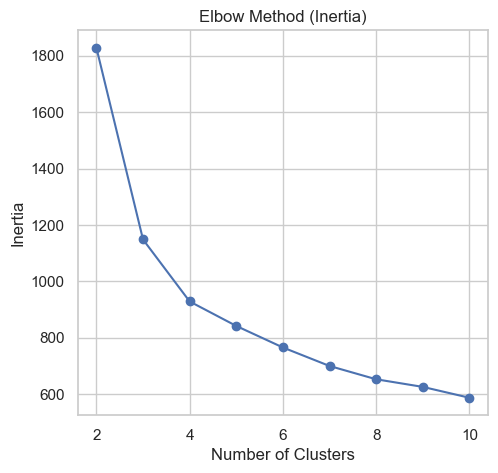

In [21]:
# Elbow Plot
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(K, inertias, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

Text(0, 0.5, 'Silhouette')

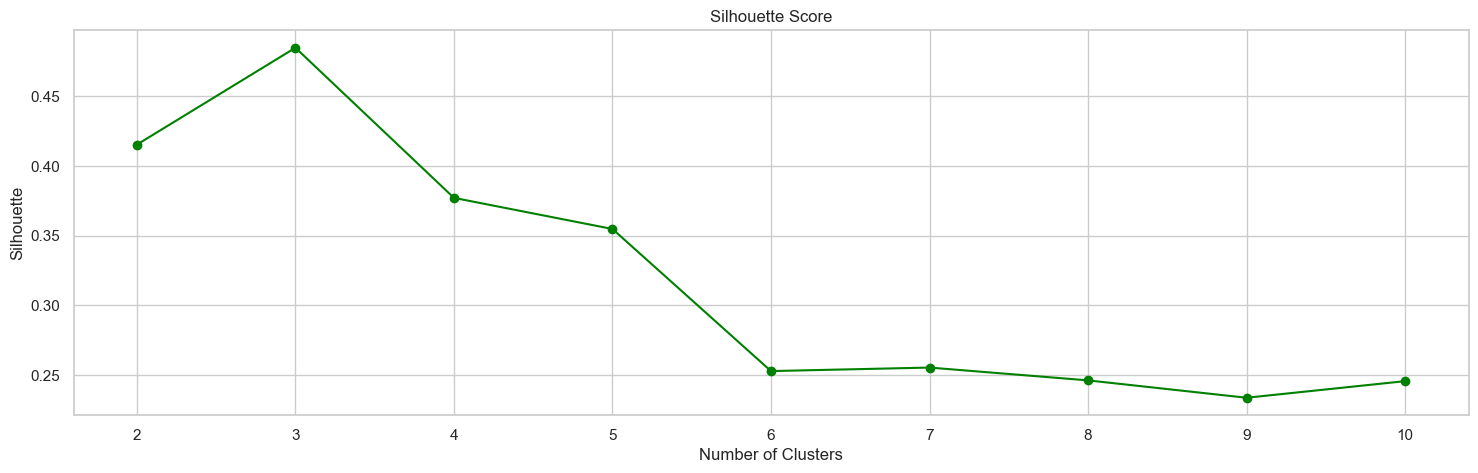

In [22]:
# Silhouette Plot
plt.figure(figsize=(18, 5))
plt.plot(K, silhouettes, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette")

Text(0, 0.5, 'Calinski Score')

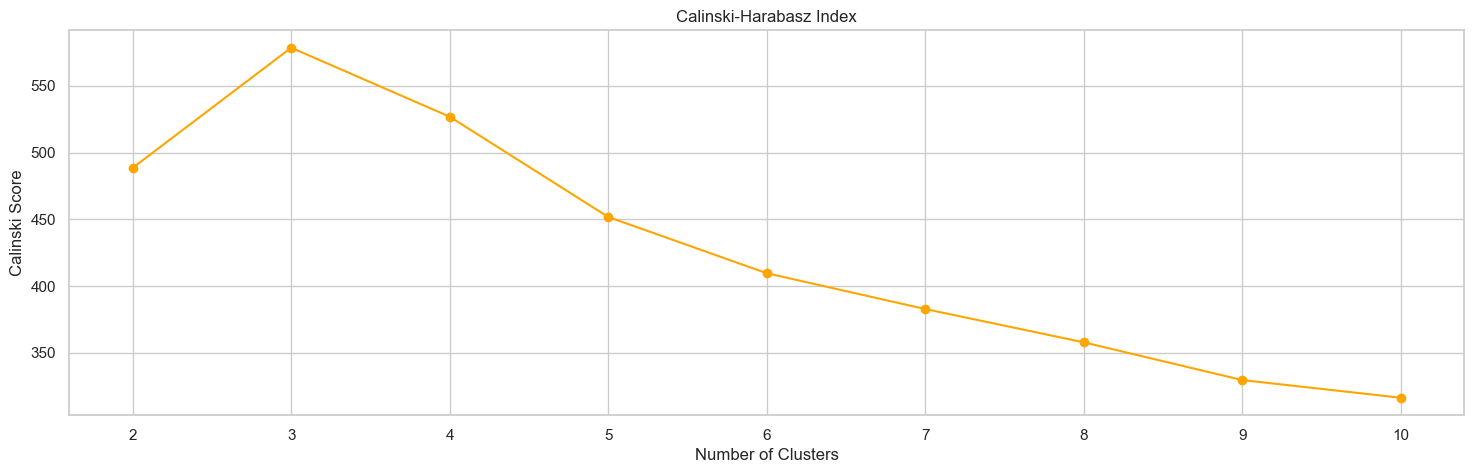

In [23]:
# Calinski-Harabasz Plot
plt.figure(figsize=(18, 5))
plt.plot(K, calinskis, marker='o', color='orange')
plt.title("Calinski-Harabasz Index")
plt.xlabel("Number of Clusters")
plt.ylabel("Calinski Score")

Based on the evaluation metrics, the optimal number of clusters is 3.

In [24]:
n_clusters = 3

### Models

In [25]:
cluster_results = {}

In [26]:
# KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
cluster_results['KMeans'] = kmeans_labels

In [27]:
# GMM
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)
cluster_results['GMM'] = gmm_labels

In [28]:
# Agglomerative
agg = AgglomerativeClustering(n_clusters=n_clusters)
agg_labels = agg.fit_predict(X_scaled)
cluster_results['Agglomerative'] = agg_labels

In [29]:
# Evaluation Function
def evaluate_clustering(X, labels):
    return {
        "Silhouette": silhouette_score(X, labels),
        "Calinski-Harabasz": calinski_harabasz_score(X, labels),
        "Davies-Bouldin": davies_bouldin_score(X, labels)
    }

In [30]:
# Evaluate All
print("Clustering Evaluation Metrics:")
for name, labels in cluster_results.items():
    scores = evaluate_clustering(X_scaled, labels)
    print(f"\n{name}:")
    for metric, score in scores.items():
        print(f"  {metric}: {score:.4f}")

Clustering Evaluation Metrics:

KMeans:
  Silhouette: 0.4848
  Calinski-Harabasz: 578.4379
  Davies-Bouldin: 0.7379

GMM:
  Silhouette: 0.4852
  Calinski-Harabasz: 577.5985
  Davies-Bouldin: 0.7334

Agglomerative:
  Silhouette: 0.4852
  Calinski-Harabasz: 578.3780
  Davies-Bouldin: 0.7348


To determine the most effective clustering approach, we evaluated KMeans, Gaussian Mixture Model (GMM), and Agglomerative Clustering using three internal validation metrics: Silhouette Score, Calinski-Harabasz Index, and Davies-Bouldin Score. After removing duplicate customer records and optimizing for 3 clusters, all three models achieved nearly identical performance.

GMM and Agglomerative Clustering both produced the highest Silhouette Score (0.4852), indicating well-separated and cohesive clusters. KMeans achieved a slightly higher Calinski-Harabasz Index (578.44), while GMM had the lowest Davies-Bouldin Score (0.7334), suggesting slightly better compactness and separation. Given the marginal differences between models, any of the three could be considered valid.

However, for interpretability and consistency with hierarchical insights, **Agglomerative Clustering** was selected as the final model for segmentation.


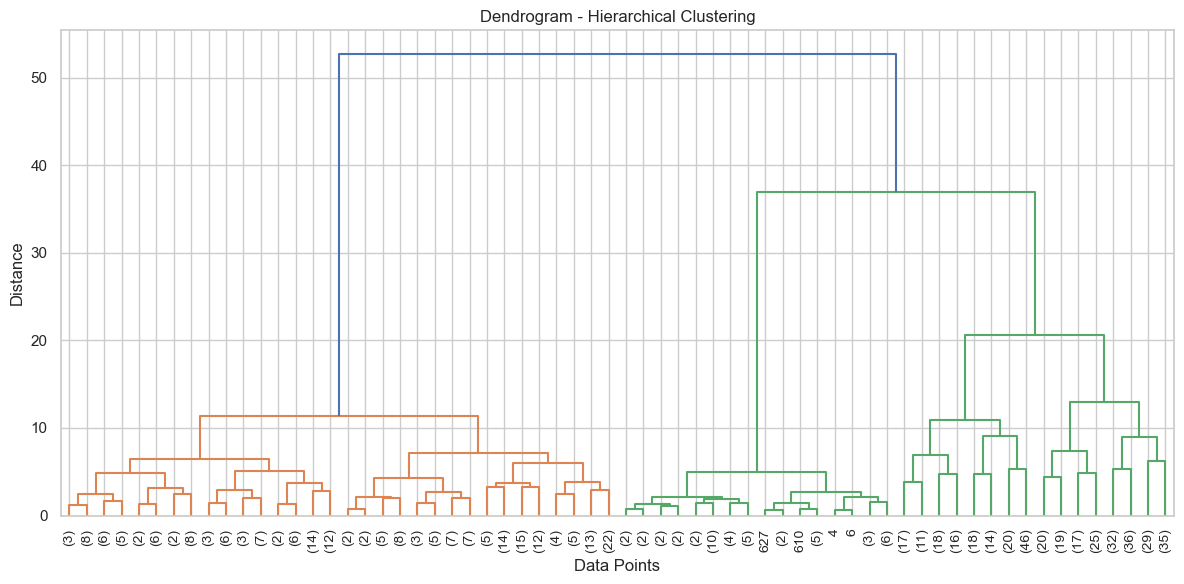

In [31]:
# Dendogram
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=5, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogram - Hierarchical Clustering")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [32]:
df["Cluster"] = cluster_results["Agglomerative"]

In [33]:
#  Cluster-level average
cluster_means = df.groupby("Cluster").mean()

global_mean = df.drop(columns="Cluster").mean()
deviation = (cluster_means - global_mean).round(2)

print("Feature deviations from global mean (by cluster):")
display(deviation)

Feature deviations from global mean (by cluster):


,Total_Credit_Cards,Total_visits_bank,Total_calls_made,Avg_Credit_Limit_log,Total_visits_online_log
Cluster,,,,,
0,0.82,1.10,-1.62,0.16,-0.46
1,-2.27,-1.45,3.27,-0.68,0.45
2,4.08,-1.80,-2.51,1.82,1.43



Segment Profiles Based on Agglomerative Clustering:


Total_Credit_Cards        Total_visits_bank        Total_calls_made  \
                      mean median              mean median             mean   
Cluster                                                                       
0                     5.51    6.0              3.49    3.0             1.99   
1                     2.42    2.0              0.95    1.0             6.88   
2                     8.78    9.0              0.59    1.0             1.10   

               Avg_Credit_Limit_log        Total_visits_online_log         
        median                 mean median                    mean median  
Cluster                                                                    
0          2.0                10.16  10.37                    0.57   0.69  
1          7.0                 9.32   9.39                    1.48   1.61  
2          1.0                11.82  11.88                    2.45   2.48

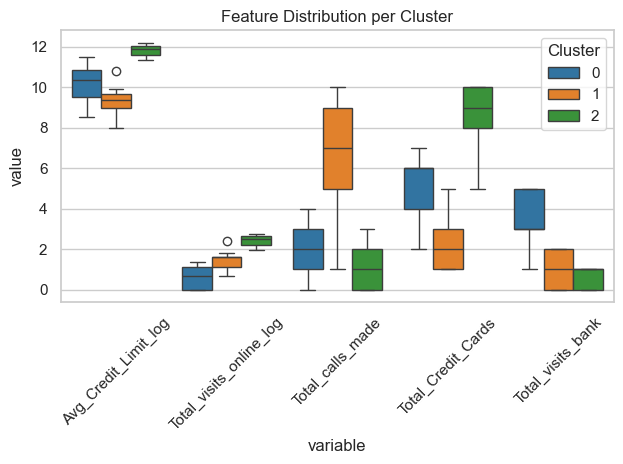

In [34]:
# mean and median per cluster
summary_stats = df.groupby('Cluster').agg(['mean', 'median']).round(2)
print("\nSegment Profiles Based on Agglomerative Clustering:")
display(summary_stats)

# Boxplot of top 5 contributing features
top_features = ["Avg_Credit_Limit_log", "Total_visits_online_log", "Total_calls_made", "Total_Credit_Cards", "Total_visits_bank"]

df[top_features + ["Cluster"]].melt(id_vars="Cluster").pipe(
    lambda d: sns.boxplot(data=d, x="variable", y="value", hue="Cluster", palette="tab10")
)

plt.title("Feature Distribution per Cluster")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Based on the deviation analysis of key behavioral and financial features, we identified **three distinct customer segments**:

**Cluster 0** represents **balanced traditional users**. These customers maintain slightly above-average credit limits and exhibit a mild preference for physical bank visits. They make fewer support calls and are somewhat disengaged with online platforms. This group reflects stable, mid-tier customers with traditional habits and moderate financial involvement.

**Cluster 1** captures the **support-dependent low-tier users**. These customers show the lowest credit limits, the fewest credit cards, and minimal branch or online activity. However, they record exceptionally high support call volumes, indicating a group that may struggle with self-service tools or frequently require assistance. Their behavior suggests low autonomy and potentially high service costs.

**Cluster 2** represents the **high-value digital-first customers**. They maintain the highest credit limits, own the most credit cards, and prefer online engagement. They avoid both branches and support calls, pointing to a self-sufficient, tech-savvy, and profitable segment with strong digital adoption.

Overall, the clusters are differentiated by financial capacity (credit limits and products), channel preference (digital vs. physical), and level of independence, offering actionable insight for personalized marketing, product bundling, and support allocation strategies.

In [35]:
print("\nCluster Sizes:")
print(df["Cluster"].value_counts())


Cluster Sizes:
Cluster
0    373
1    222
2     49
Name: count, dtype: int64


In [36]:
# Assign Agglomerative cluster labels to DataFrame
df["Cluster"] = cluster_results["Agglomerative"]


cluster_names = {
    0: "Mid-Tier Traditional",
    1: "Low-Engagement Conservative",
    2: "High-Value Digital",
    3: "Support-Dependent Low Value"
}

df["Cluster_Label"] = df["Cluster"].map(cluster_names)

In [37]:
df.head()

,Total_Credit_Cards,Total_visits_bank,Total_calls_made,Avg_Credit_Limit_log,Total_visits_online_log,Cluster,Cluster_Label
0,2,1,0,11.512935,0.693147,0,Mid-Tier Traditional
1,3,0,9,10.819798,2.397895,1,Low-Engagement Conservative
2,7,1,4,10.819798,1.386294,0,Mid-Tier Traditional
3,5,1,4,10.308986,0.693147,0,Mid-Tier Traditional
4,6,0,3,11.512935,2.564949,2,High-Value Digital


In [38]:
pca_full = PCA()
pca_full.fit(X_scaled)

PCA()

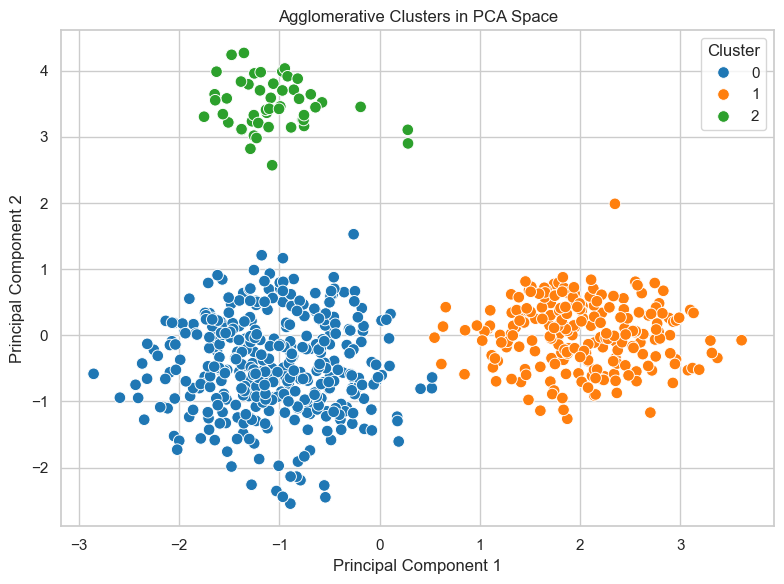

In [39]:
# Fit PCA for 2D projection
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_scaled)

# Scatterplot of clusters in 2D PCA space
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df["Cluster"], palette='tab10', s=70)
plt.title("Agglomerative Clusters in PCA Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [40]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

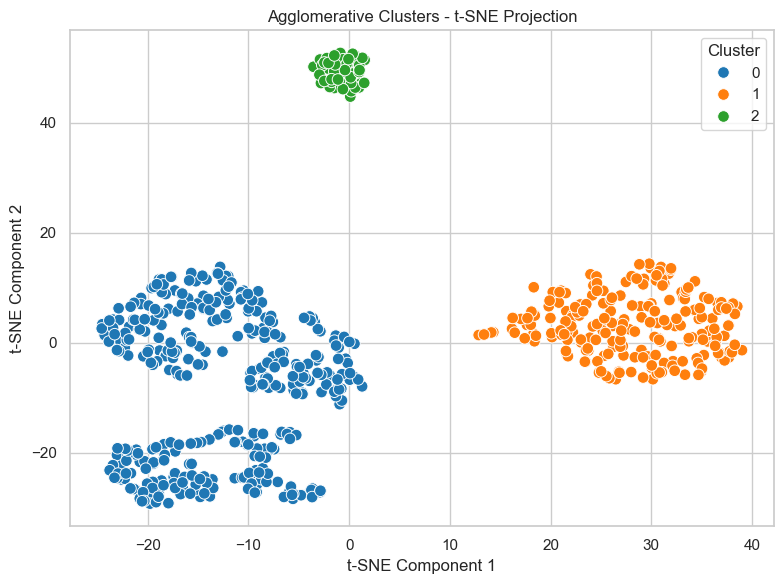

In [41]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df["Cluster"], palette='tab10', s=70)
plt.title("Agglomerative Clusters - t-SNE Projection")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

To assess the quality and separation of clusters generated by Agglomerative Clustering, we employed two dimensionality reduction techniques: Principal Component Analysis (PCA) and t-distributed Stochastic Neighbor Embedding (t-SNE).

The PCA projection shows reasonable cluster separation in a linear space. Cluster 2 stands out clearly at the top, while Clusters 0 and 1 remain well-separated but exhibit some mild proximity due to overlapping variance directions. Since PCA captures maximum variance rather than nonlinear relationships, slight overlaps are expected.

The t-SNE projection, being a nonlinear technique, reveals more distinct and compact cluster formations. All three clusters are visibly isolated with clear boundaries, indicating strong underlying structure in the data and validating the effectiveness of our clustering solution.

Together, these visualizations reinforce the robustness of the segmentation and highlight meaningful behavioral differences across customer groups.

## PCA

In [42]:
# Cumulative explained variance
explained_variance = np.cumsum(pca_full.explained_variance_ratio_)

In [43]:
explained_variance

array([0.49957781, 0.78710576, 0.87263769, 0.9400589 , 1.        ])

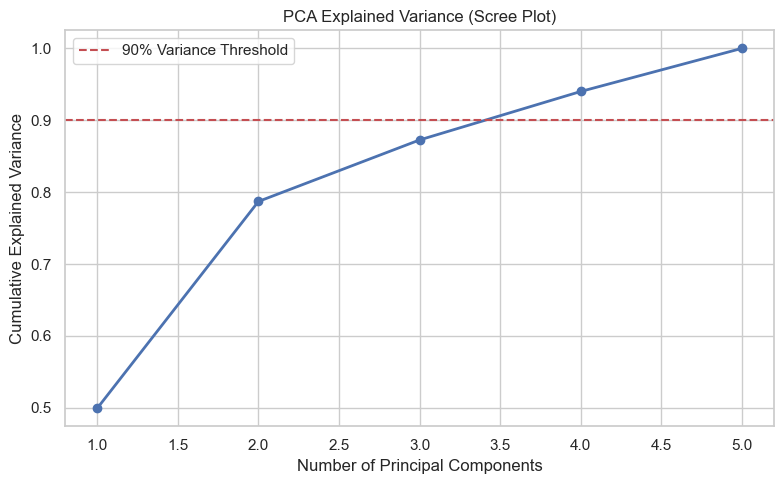

In [44]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', linewidth=2)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Threshold')
plt.title("PCA Explained Variance (Scree Plot)")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
print(f"Explained Variance: PC1 = {pca_2d.explained_variance_ratio_[0]:.2f}, PC2 = {pca_2d.explained_variance_ratio_[1]:.2f}")

Explained Variance: PC1 = 0.50, PC2 = 0.29


In [48]:
loadings = pd.DataFrame(
    pca_2d.components_.T,
    index = df.columns.drop(["Cluster", "Cluster_Label"]),
    columns=["PC1", "PC2"]
)

# Top drivers of PC1
print("Top features influencing PC1:")
print(loadings["PC1"].abs().sort_values(ascending=False).head())

# Top drivers of PC2
print("\nTop features influencing PC2:")
print(loadings["PC2"].abs().sort_values(ascending=False).head())

Top features influencing PC1:
Total_calls_made           0.556770
Total_Credit_Cards         0.502094
Total_visits_bank          0.440723
Avg_Credit_Limit_log       0.382168
Total_visits_online_log    0.312443
Name: PC1, dtype: float64

Top features influencing PC2:
Total_visits_online_log    0.624538
Avg_Credit_Limit_log       0.525734
Total_visits_bank          0.466356
Total_Credit_Cards         0.336109
Total_calls_made           0.055658
Name: PC2, dtype: float64


- Cumulative Explained Variance:
  - PC1: 50%
  - PC1 + PC2: 79%
The first two principal components capture nearly **80%** of the variance, making them suitable for 2D cluster visualization without major information loss.


Principal Component 1 (PC1)
Top contributing features:
- Total Calls Made: 0.55
- Total Credit Cards: 0.50
- Total Bank Visits: 0.44
- Avg Credit Limit (log): 0.38
- Total Online Visits (log): 0.3111

PC1 appears to represent overall **engagement intensity**, combining communication, product holding, and financial size.

Principal Component 2 (PC2)
Top contributing features:
- Total Online Visits (log): 0.62
- Avg Credit Limit (log): 0.52
- Total Bank Visits: 0.46
- Total Credit Cards: 0.33
- Total Calls Made: 0.055

PC2 captures a contrast between **digital vs. traditional** behaviors, with emphasis on **online usage and credit strength**.
